# Exercises: Analog to Digital Encoding

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from typing import Union, Callable, Tuple
from pathlib import Path

%matplotlib inline

## Describing Our Analog Signal

(1.3.1) Write a function `analog_signal` that takes in a float or a NumPy array of times and evaluates the following "Logistic Cumulative Distribution Function" at those times
\begin{equation}
f(t)=\frac{1}{1+e^{-10(t-1)}}.
\end{equation}

Note that the choice of this function is not particularly important, and the remaining exercises can be done by rewriting `analog_signal` to be any function of interest.

In [2]:
def analog_signal(times: np.ndarray) -> np.ndarray:
    """
    Given an array of times, returns the value of an analog signal at those times.
    
    Parameters
    ----------
    times : numpy.ndarray
        The time(s) at which to evaluate the analog signal.
    
    Returns
    -------
    numpy.ndarray
        The value of the analog signal at the given times.
    """
    # This should leverage vectorized numpy operations (i.e. you should not use a for-loop)
    # STUDENT CODE HERE
    return 1/(1+ np.exp(1) ** (-10*(times-1)))

In [3]:
# Testing things! Run this. If you see an assertion error
# then there is something that needs to be adjusted with
# your `analog_signal` function

times = np.array([0.0, 1.0, 2.0])
samples = analog_signal(times)

assert isinstance(samples, np.ndarray)
assert samples.shape == (3,)
assert np.allclose(samples, np.array([4.53978687e-05, 5.00000000e-01, 9.99954602e-01]))

Let's plot this function. You should see an S-shaped curve whose y-values fall within the range $(0, 1)$

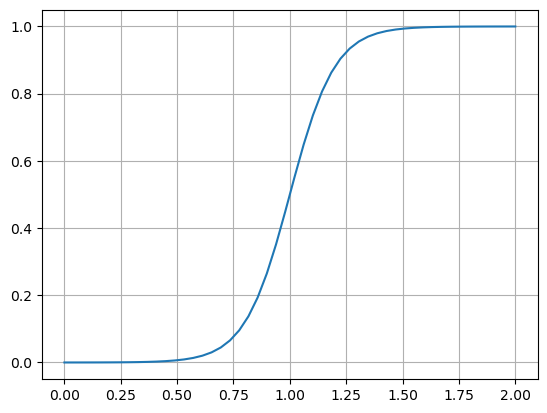

In [4]:
fig, ax = plt.subplots()

t = np.linspace(0, 2)
y = analog_signal(t)
ax.plot(t, y)
ax.grid(True)

## Reviewing Temporal and Quantization Utilities

We will now investigate how the process of PCM can affect the fidelity of our audio signal.
Let's start by defining a few functions.
If you have not completed the **Writing a Sampler** and **Quantization** reading comprehension exercises [from the previous section](https://rsokl.github.io/CogWeb/Audio/digitizing_signals.html), you may wish to go back and work those problems before proceeding here.

Below are two functions, `temporal_sampler` and `quantize`, which in tandem allow us to sample and quantize a given analog signal to construct a digital signal.

Study the signature, docstring, and body of `temporal_sampler`.

In [5]:
def temporal_sampler(
    signal: Callable[[np.ndarray], np.ndarray], *, duration: float, sampling_rate: float
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extracts samples from an analog signal according to the specified sampling rate,
    returning the times and the corresponding samples extracted at those times.

    Parameters
    ----------
    signal : Callable[[ndarray], ndarray]
        Another Python function (i.e. a "callable"), which behaves like f(t)
        and accepts a time value (in seconds) as an input and returns a
        measurement (e.g. in volts) as an output. You can expect this to behave like
        a vectorized function i.e. it can be passed a NumPy-array of input times
        and it will return a corresponding array of measurements.

    duration : float
        The duration of the signal, specified in seconds (a non-negative float)

    sampling_rate : float
        The sampling rate specified in Hertz.

    Returns
    -------
    (times, samples) : Tuple[ndarray, ndarray]
        The shape-(N,) array of times and the corresponding shape-(N,) array
        samples extracted from the analog signal

    """
    N_samples = np.floor(sampling_rate * duration) + 1

    # shape-(N,) array of times at which we sample the analog signal
    times = np.arange(N_samples) * (1 / sampling_rate)  # seconds

    # shape-(N,) array of samples extracted from the analog signal
    samples = signal(times)

    return times, samples


Use `temporal_sampler` to extract samples from `analog_signal` for using a sampling rate of 1 sample per second over a duration of 2 seconds.


In [6]:
times, samples = temporal_sampler(analog_signal, duration=2, sampling_rate=1)
print(f"times: {times}")
print(f"samples: {samples}")

times: [0. 1. 2.]
samples: [4.53978687e-05 5.00000000e-01 9.99954602e-01]


Do the values of `times` that you see make sense? Try modifying the duration and/or sampling rate and see if you can predict what `times` you will see.

What is the relationship between the printed times and samples? Use the array `times` and your function `analog_signal` to reproduce the values in the array `samples`

In [7]:
# STUDENT CODE HERE
print(analog_signal(times))

[4.53978687e-05 5.00000000e-01 9.99954602e-01]


Now let's plot `analog_signal` sampled with multiple different sampling rates. Study the following plot and see if you understand the patterns that you see. Discuss with your neighbor or TA.

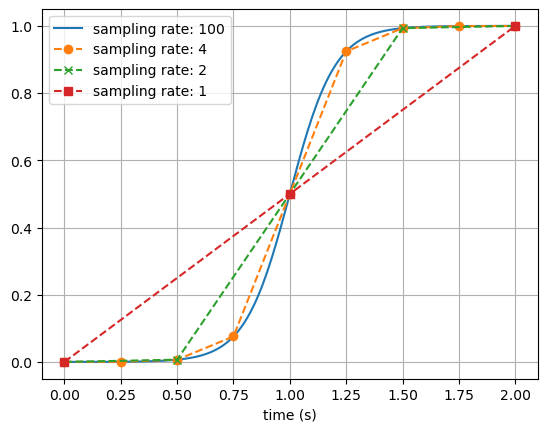

In [8]:
# Run this cell
fig, ax = plt.subplots()

for plt_kwds, sampling_rate in zip(
    [
        dict(ls="-"),
        dict(ls="--", marker="o"),
        dict(ls="--", marker="x"),
        dict(ls="--", marker="s"),
    ],
    [100, 4, 2, 1],
):
    ax.plot(
        *temporal_sampler(analog_signal, duration=2.0, sampling_rate=sampling_rate),
        **plt_kwds,
        label=f"sampling rate: {sampling_rate}",
    )


ax.legend()
ax.set_xlabel("time (s)")
ax.grid(True)

Study the signature, docstring, and body of `quantize`.

In [9]:
def quantize(samples: np.ndarray, bit_depth: int) -> np.ndarray:
    """
    Given an array of N samples and a bit-depth of M, return the array of
    quantized samples derived from the domain [samples.min(), samples.max()]
    that has been quantized into 2**M evenly-spaced values.

    Parameters
    ----------
    samples : numpy.ndarray, shape-(N,)
        An array of N samples

    bit_depth: int
        The bit-depth, M, used to quantize the samples among
        2**M evenly spaced values spanning [samples.min(), samples.max()].

    Returns
    -------
    quantized_samples : numpy.ndarray, shape-(N,)
        The corresponding array where each sample has been replaced
        by the nearest quantized value

    Examples
    --------
    >>> import numpy as np
    >>> samples = np.array([0, .25, .75, 1])
    >>> quantize(samples, 1) # quantize among 2 values
    array([0., 0., 1., 1.])
    >>> quantize(samples, 1) # quantize among 4 values
    array([0., 0.3333, .6666, 1.])
    """

    assert bit_depth <= 14, "Exceeding this bit-depth might tank your computer!"

    # create the 2**M evenly-spaced quantized values,
    # spanning [samples.min(), samples.max()]
    quantized_values = np.linspace(samples.min(), samples.max(), 2 ** bit_depth)

    # Broadcast subtract: shape-(N, 1) w/ shape-(2**M ,) -> shape(N, 2**M)
    # `abs_differences[i]` is the absolute difference between sample-i and
    # each of the 2**M quantized values
    abs_differences = np.abs(samples[:, np.newaxis] - quantized_values)

    # For each sample, find which quantized value it is closest to.
    # Produced shape-(N,) array on indices on [0, 2**M)
    bin_lookup = np.argmin(abs_differences, axis=1)

    # Populate a shape-(N,) array, where each sample has been
    # replaced by its nearest quantized value. This leverages
    # advanced integer-array indexing
    return quantized_values[bin_lookup]

Following the same code that you used above, sample `analog_signal` using a sampling rate of 5.0 over a duration of 2.0.

In [10]:
times, samples = temporal_sampler(analog_signal, duration=2.0, sampling_rate=5.0) #
print(samples)

[4.53978687e-05 3.35350130e-04 2.47262316e-03 1.79862100e-02
 1.19202922e-01 5.00000000e-01 8.80797078e-01 9.82013790e-01
 9.97527377e-01 9.99664650e-01 9.99954602e-01]


Now use `quantize` to quantize these samples using a bit-depth of 1. How many *distinct* values do you expect to see among these quantized samples?

In [11]:
quantized_samples = quantize(samples, bit_depth=1) #
print(quantized_samples)

[4.53978687e-05 4.53978687e-05 4.53978687e-05 4.53978687e-05
 4.53978687e-05 4.53978687e-05 9.99954602e-01 9.99954602e-01
 9.99954602e-01 9.99954602e-01 9.99954602e-01]


What is the relationship that you see between `samples` and `quantized_samples`? How would things change if you changed the bit-depth to 2?

Let's plot `analog_signal` using multiple bit-depths. Study the following plot and check that you can explain the patterns that manifest. Check your understanding with a neighbor or TA.

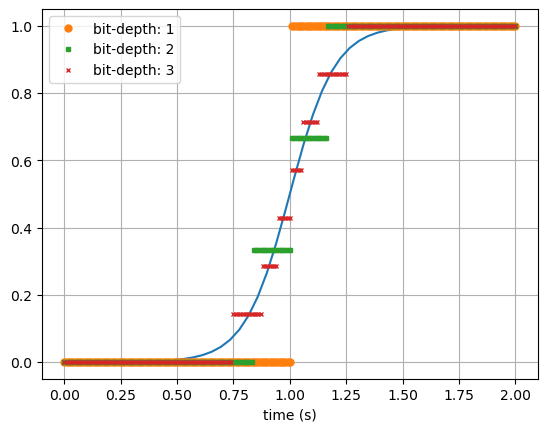

In [12]:
fig, ax = plt.subplots()

def quantized_plot(times, samples, bit_depth=None, **plt_kw):
    if bit_depth is not None:
        samples = quantize(samples, bit_depth=bit_depth)
    ax.plot(times, samples, **plt_kw, label=f"bit-depth: {bit_depth}")
    return ax

times, samples = temporal_sampler(analog_signal, duration=2., sampling_rate=100)

t = np.linspace(0, 2)
y = analog_signal(t)
ax.plot(t, y)

for marker, depth in zip(["o", "s", "x"], [1, 2, 3]):
    quantized_plot(times, samples, bit_depth=depth, marker=marker, ls=" ", markersize=5/(depth)**.5)

ax.legend()

ax.set_xlabel("time (s)")
ax.grid(True)


## Creating an End-to-End Analog-to-Digital Conversion Function

(1.3.2) Using the above functions, write a function `analog_to_digital` that takes in

* an analog signal (a Python-function $f(t)$)
* sampling rate ($f_s$)
* bit-depth ($N_d$)
* signal duration ($T$)

and yields a tuple of two numpy arrays corresponding to: 

1. the times, $(t_n)_{n=0}^{N-1}$, at which the samples were taken 
2. the corresponding digital samples, $(f(t_n))_{n=0}^{N-1}$, extracted from the analog signal at those times and quantized using the provided bit-depth

**Hint: you will first want to extract temporal samples from the analog signal, then quantize those samples.
Given the functions provided above, this should be a relatively short/simple function!**

Note that the `*` in the following function signature makes `sampling_rate`, `bit_depth`, and `duration` ["keyword-only" arguments](https://www.pythonlikeyoumeanit.com/Module2_EssentialsOfPython/Functions.html#Arguments) – they can only be passed their values by name when invoking the function.E.g. `analog_to_digital(signal, sampling_rate=44100, bit_depth=8, duration=2.0)`.
This is so the user can't accidentally flip values for, say, the duration and the sampling rate.

In [13]:
def analog_to_digital(
    analog_signal: Callable[[np.ndarray], np.ndarray],
    *,
    sampling_rate: float,
    bit_depth: int,
    duration: float
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Digitizes a given analog signal based on desired sampling rate and bit-depth.
    
    Parameters
    ----------
    analog_signal : Callable[[ndarray], ndarray]
        Another Python function, f(t), which accepts a time value (in seconds) as
        an input and returns a measurement (in volts) as an output.
    
    sampling_rate : float
        The sampling rate specified in Hertz.
    
    bit_depth: int
        The bit-depth, M, used to quantize the samples among
        2**M evenly spaced values spanning [samples.min(), samples.max()].
    
    duration : float
        The duration of the signal, specified in seconds (a non-negative float).
    
    Returns
    -------
    (times, digital_signal) : Tuple[ndarray, ndarray]
        The shape-(N,) array of times and the corresponding
        shape-(N,) array representing the sampled & quantized digital signal.
    """
    # STUDENT CODE HERE
    times, samples = temporal_sampler(
        analog_signal, duration=duration, sampling_rate=sampling_rate
    )
    digital_signal = quantize(samples, bit_depth)

    return times, digital_signal


### Testing Our Code

Let's test out our work so far.
The following cell will plot a "continuous" version of $f(t)$ (`analog_signal`), and then will use our implementation of `analog_to_digital` to plot discrete samples of the function on top of it.

The duration ($T$), sampling rate ($f_s$), and bit-depth ($N_d$) are set at the top of the code cell.
Based on these values, do the plotted discrete samples occur at the appropriate time intervals given $f_s$? 
Are there the appropriate number of distinct measurement values, given $N_d$?

Try changing these values to see that `analog_to_digital` continues to produce the appropriate output.

/var/folders/rk/9p1bkflx7xqfp9blzn6sypv00000gn/T/ipykernel_59378/586364859.py:26: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax.stem(


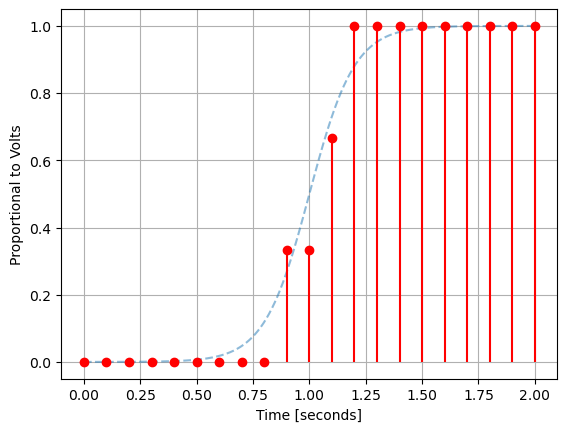

In [14]:
# feel free to change these
duration = 2  # seconds
sample_rate = 10  # Hz
bit_depth = 2  # bits


# You don't need to change any of the remaining code
# simply read through it and then run this cell
fig, ax = plt.subplots()

# we densely sample the analog analog_signal to make it look like
# it is continuous
dense_t = np.linspace(0, duration, 10000)  # seconds
ax.plot(dense_t, analog_signal(dense_t), ls="--", alpha=0.5)


# extract samples that have been discretized in time and quantized
times, samples = analog_to_digital(
    analog_signal=analog_signal,
    duration=duration,
    sampling_rate=sample_rate,
    bit_depth=bit_depth,
)

# plot our digital samples on top of the analog signal
ax.stem(
    times,
    samples,
    linefmt="red",
    markerfmt="ro",
    basefmt=" ",
    use_line_collection=True,
)
ax.set_xlabel("Time [seconds]")
ax.set_ylabel("Proportional to Volts")
ax.grid(True)

### Examining the Effects of Sampling Rate and Bit-Depth

(1.3.3) Let's finally take a look at how different choices of `sampling_rate` and `bit_depth` will affect our digital signal.
Below is code that will plot the digital signal for various choices of sampling rate and bits.
In particular, from left to right, the columns represent bit-depths of $2$, $4$, and $8$.
Top to bottom, the rows represent sampling rates of $1\:\mathrm{Hz}$, $10\:\mathrm{Hz}$, and $100\:\mathrm{Hz}$.

Try changing the sampling rates, bit depth, and analog signal used and see how the digital signal is affected.

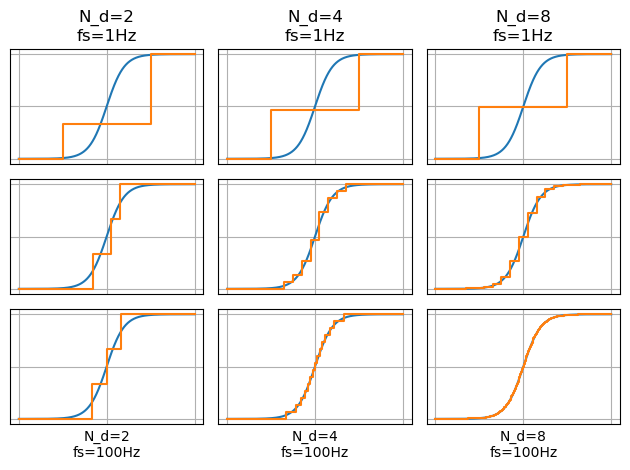

In [15]:
sampling_rates = [1, 10, 100]  # Hz
bit_depths = [2, 4, 8]  # bits

# Run this cell - you don't need to change anything below this comment

fig, axes = plt.subplots(nrows=len(sampling_rates), ncols=len(bit_depths))

min_ = 0
max_ = 2
duration = max_ - min_

dense_times = np.linspace(min_, max_, 10 ** 5)
dense_sampling = analog_signal(dense_times)

for i, sr in enumerate(sampling_rates): # sampling rates
    for j, bits in enumerate(bit_depths): # bit-depths
        axes[i, j].plot(dense_times, dense_sampling)

        sampling_time, digital_signal = analog_to_digital(
            analog_signal, sampling_rate=sr, bit_depth=bits, duration=duration
        )
        axes[i, j].step(sampling_time, digital_signal, where="mid")

        for tic in axes[i, j].xaxis.get_major_ticks():
            tic.tick1line.set_visible(False)
            tic.tick2line.set_visible(False)
            tic.label1.set_visible(False)
            tic.label2.set_visible(False)
        for tic in axes[i, j].yaxis.get_major_ticks():
            tic.tick1line.set_visible(False)
            tic.tick2line.set_visible(False)
            tic.label1.set_visible(False)
            tic.label2.set_visible(False)

        if i == 0 or i == 2:
            if i == 0:
                axes[i, j].set_title(f"N_d={bits}\nfs={sr}Hz")
            else:
                axes[i, j].set_xlabel(f"N_d={bits}\nfs={sr}Hz")

        axes[i, j].grid(True)
fig.tight_layout()

## Hearing the Effects of Sampling Rate and Bit-Depth

**A Quick Aside: Raw Strings**

We are going to be be writing strings as paths to files on our computers.
This can lead to some unexpected complications that can be quite confusing at first. 
Consider the following Windows-format path:

```
"D:\Music\new_song.mp3"
```

Let's try printing this string in Python:

```python
# Our path contains \n, which is treated as a single newline character
>>> print("D:\Music\new_song.mp3")
D:\Music
ew_song.mp3
```

Recall that `"\n"` is treated as a *single*, special character in Python; in particular, it represents a newline character.
`"\n"` is one of several so-called escape characters (e.g. `"\t"` is the escape character for tab).

We want to avoid these escape characters from affecting our file-paths.
Indeed, the `\` character is supposed to serve as a directory separator on a Windows system.
Fortunately, we can tell Python to forego its interpretation of escape characters by making a string into a raw-string.
We do this by pre-pending an `r` *before* the opening quotation mark of the string.

```python
# normal string
"hello"

# raw string
r"hello"
```
```python
# Creating a raw-string of our path by pre-pending an
# r before the string prevents Python from looking for
# escape characters
>>> print(r"D:\Music\new_song.mp3")
D:\Music\new_song.mp3
```

Thus it is prudent to store string paths as raw strings throughout our code.

**Back to Digitizing Signals!** 

Finally let's take a look at how we can modify music files that have already been recorded.
We can use Librosa to work with music files in Python.
Start by picking out a song you have on your computer, and use Librosa to load the first $11$ seconds of said song.

Note that on Windows, you can hold Shift and right-click on your audio file; among the options that pop-up, there should be a "Copy as path" option, which is a convenient way to get a string representation of the path to that file on your computer.
On MacOS, this can be similarly accomplished by right-clicking then holding Option - in the menu will be a "Copy <file name> as Pathname", which will copy the file path to your clipboard.

In [16]:
# using librosa to read in audio samples from a sound file (e.g. .mp3 or .wav) as a numpy array 

# The r in front to the string is to treat the string as a "raw string".
# This guarantees that characters like `\n` get interpreted literally,
# and not in special ways (e.g. like a line break)
local_song_path = r"Documents/Repositories/Academic/BWSI-CogWorks-2023/Class Assignments/week1/Day2/data/BP_ET_minor.ogg"

duration = 11  # seconds

# load the digital signal for the first 11 seconds of the song
samples, sampling_rate = librosa.load(local_song_path, sr=44100, mono=True, duration=duration)

ImportError: dlopen(/Users/aadishah/anaconda3/envs/week1/lib/python3.8/site-packages/scipy/linalg/_fblas.cpython-38-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib
  Referenced from: <2E938FBF-0DBB-3A47-B0D9-A194C6124397> /Users/aadishah/anaconda3/envs/week1/lib/python3.8/site-packages/scipy/linalg/_fblas.cpython-38-darwin.so
  Reason: tried: '/Users/aadishah/anaconda3/envs/week1/lib/python3.8/site-packages/scipy/linalg/liblapack.3.dylib' (no such file), '/Users/aadishah/anaconda3/envs/week1/lib/python3.8/site-packages/scipy/linalg/../../../../liblapack.3.dylib' (no such file), '/Users/aadishah/anaconda3/envs/week1/lib/python3.8/site-packages/scipy/linalg/liblapack.3.dylib' (no such file), '/Users/aadishah/anaconda3/envs/week1/lib/python3.8/site-packages/scipy/linalg/../../../../liblapack.3.dylib' (no such file), '/Users/aadishah/anaconda3/envs/week1/bin/../lib/liblapack.3.dylib' (no such file), '/Users/aadishah/anaconda3/envs/week1/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)

(1.3.4) Write some simple code to investigate the following:
 
 - What is the data type of the array `samples`?
 - What is the shape of `samples`? 
   - Does the number of elements in the array make sense based on the sampling rate and the duration of the clip?
 - What are the minimum and maximum values stored in the array?
   - What does this imply about the relative "loudness" songs that are loaded by librosa in this way?
 

In [ ]:
# STUDENT CODE HERE
# The dtype of `samples` is float32
print(f"dtype of `samples`: {samples.dtype}")

# the number of elements in `samples` should equal (duration-in-seconds x 44100 Hz)
print(f"shape of `samples`: {samples.shape}")
assert len(samples) == duration * sampling_rate

# the amplitude (loudness) of a recording gets normalized by librosa
print(f"[min, max] of `samples`: [{samples.min()}, {samples.max()}]")

You can listen to this audio clip using the following

In [ ]:
Audio(samples, rate=sampling_rate)

(1.3.5) There is a very good chance that the recording was digitized at a sampling rate of $f_s=44,100\:\mathrm{Hz}$ and with a bit-depth of $N_d=16$.

What would our music would sound like if it were recorded with a lower sampling rate and/or bit-depth?

To do this, we'll start by re-sampling the data we loaded in, thus changing the sampling rate of the signal.
Of course it would not be possible to re-sample the data at a *higher* sampling rate than that originally used, but we can still down-sample the data by skipping over samples.

Let's say we wanted to sample with a sampling rate of $1,000\:\mathrm{Hz}$.
We initially recorded with a sampling rate of $44,100\:\mathrm{Hz}$, meaning our digital signal has $11\:\mathrm{sec}\cdot44,100\:\mathrm{Hz}=485,100$ samples.
However, we want to re-sample our signal such that we only have $11\:\mathrm{sec}\cdot1,000\:\mathrm{Hz}=11,000$ samples.
This means that to re-sample our song at $1,000\:\mathrm{Hz}$, we will need to only take every $\frac{485,100}{11,000}=44.1^\text{th}$ sample.
Since we can only skip over an integer number of samples, we will have to settle for every $\big\lfloor\frac{485,100}{11,000}\big\rfloor=44^\text{th}$ sample.

We can "resample" our data in this way as,

```python
skip = 44
resampled_signal = samples[::skip]  # audio at 1000 Hz
```

Now, generalize this code so that you can specify any new sampling rate (that is less than the original rate) so that `skip` reflects the appropriate corresponding value.
Re-sample the recording at a rate of $2,000\:\mathrm{Hz}$.

In [ ]:
sampling_rate = 2000

skip = len(samples) // (duration * sampling_rate) # compute this using `duration`, `sampling_rate` and `len(samples)`
resampled_signal = samples[::skip]


Note that this re-sampling will not be a perfect process.
You can easily check that the size of the re-sampled signal is not what you would expect it to be.

This has to do with the fact that we can only truly re-sample the original analog signal if we choose our new sampling rate to be a factor of the original sampling rate.
To re-sample our original signal for non-factor sampling rates would require more advanced signal processing.
However, we will take this method of re-sampling to be sufficient for our purposes.

Now, we could play our re-sampled signal out at a rate of $2,000\:\mathrm{Hz}$, but there is a good chance that your computer will not be able to actually play this.
We will thus have to get a bit clever and "stretch out" our signal back to be re-played at $44,100\:\mathrm{Hz}$.
We can use [numpy.repeat](https://numpy.org/doc/stable/reference/generated/numpy.repeat.html) to do this.

In [ ]:
# "stretches" signal so that it can be played by audio plugin
resampled_signal = np.repeat(resampled_signal, skip)

Finally, replay the re-sampled signal using

In [ ]:
Audio(resampled_signal, rate=44100)

and note how different the re-sampled audio sounds to the original song.
Which of the original notes (high frequencies or low frequencies) can you still make out?

(1.3.6) Now that we've re-sampled the recording, let's re-quantize it as well.
To do this, we simply need to leverage the `quantize` function defined earlier, passing in the recording and the desired bit-depth.
Again, we can't choose a bit-depth greater than that of the original recording, but we can always choose a lower value.

Re-quantize the re-sampled signal with a new bit-depth of $N_b=3$.

In [ ]:
resampled_requantized_signal = # quantize the resampled signal w/ bit-depth 3

Again, play the now re-quantized recording, and notice how it differs from the original clip.

In [ ]:
Audio(resampled_requantized_signal, rate=44100)

Go back and play with these numbers.
For example, try keeping the original sampling rate but then re-quantize the song at a lower bit-rate.

(1.3.7) Finally let's graphically compare our re-sampled and re-quantized song to the original.
Repeat the re-sampling and re-quantization process from above, on the original samples, now with a sampling rate of $40\:\mathrm{Hz}$ and a bit-depth of $4$.
Then plot the first $5$ seconds of each of the signals below.
Use the `plot` method for the original song and the `step` method for the modified signal.

Play around with the choices of sampling rate and bit-depth to see how changing these values impacts the digital signal.

In [ ]:
sampling_rate = 40
bit_depth = 4


# Use your code from (1.4) to resample the song clip at
# the desired sampling rate. Then apply `quantize` to 
# these samples with the appropriatebit-depth. 
# Call the result `new_signal`.

# STUDENT CODE HERE
skip = len(samples) // (duration * sampling_rate)
new_signal = samples[::skip]
new_signal = quantize(new_signal, bit_depth)

# Define `n_samples_orig`:" the number of samples associated
# with 5 seconds of an audio recording with the original 
# sampling rate of 44,100 Hz

n_samples_orig = #


# Similarly, define `n_samples_new` the number of samples associated
# with 5 seconds of an audio recording with the target sampling rate: `sampling_rate`

n_samples_new = #


fig, ax = plt.subplots(1, 1)

ax.plot(np.linspace(0, 5, n_samples_orig), samples[: n_samples_orig])
ax.step(np.linspace(0, 5, n_samples_new), new_signal[: n_samples_new], where="mid")
ax.set_xlabel("Time [seconds]")
ax.set_ylabel("Amplitude [Proportional to Volts]");